## Import Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set ()
import os
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import itertools
from sklearn.model_selection import train_test_split

print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.12.0-rc1



In [14]:
df_forehand_low=pd.read_csv('../data/forehand_low.csv')
df_forehand_high=pd.read_csv('../data/forehand_high.csv')
df_backhand_low=pd.read_csv('../data/backhand_low.csv')
df_backhand_high=pd.read_csv('../data/backhand_high.csv')

df_forehand_low

,aX,aY,aZ,gX,gY,gZ
0,-1.552612,-1.709229,-0.856689,66.528320,-226.867676,38.757324
1,-1.670166,-1.743408,-0.830078,74.340820,-237.426758,43.457031
2,-1.771118,-1.794067,-0.817871,83.984375,-247.375488,47.790527
3,-1.865112,-1.865112,-0.821289,91.430664,-256.530762,51.940918
4,-1.969604,-1.953979,-0.841675,94.055176,-265.808105,56.335449
...,...,...,...,...,...,...
14063,-0.166870,1.096558,0.483643,-153.015137,-7.751465,63.781738
14064,-0.122192,1.154663,0.454224,-142.578125,-8.789062,57.922363
14065,-0.101318,1.228516,0.443237,-126.770020,-9.460449,51.513672
14066,-0.083984,1.291992,0.443604,-107.788086,-10.314941,44.982910


In [15]:
def plot(df, column, title, ylabel):
    index = range(1, len(df)+1)

    plt.figure(figsize=(20, 10))
    plt.title(title)
    plt.xlabel("Sample #")
    plt.ylabel(ylabel)
    for column, color, label in zip(column, ['g', 'b', 'r'], ['x', 'y', 'z']):
        plt.plot(index, df[column], color, label=label, linestyle='solid', marker=',')
    plt.legend()
    plt.show()

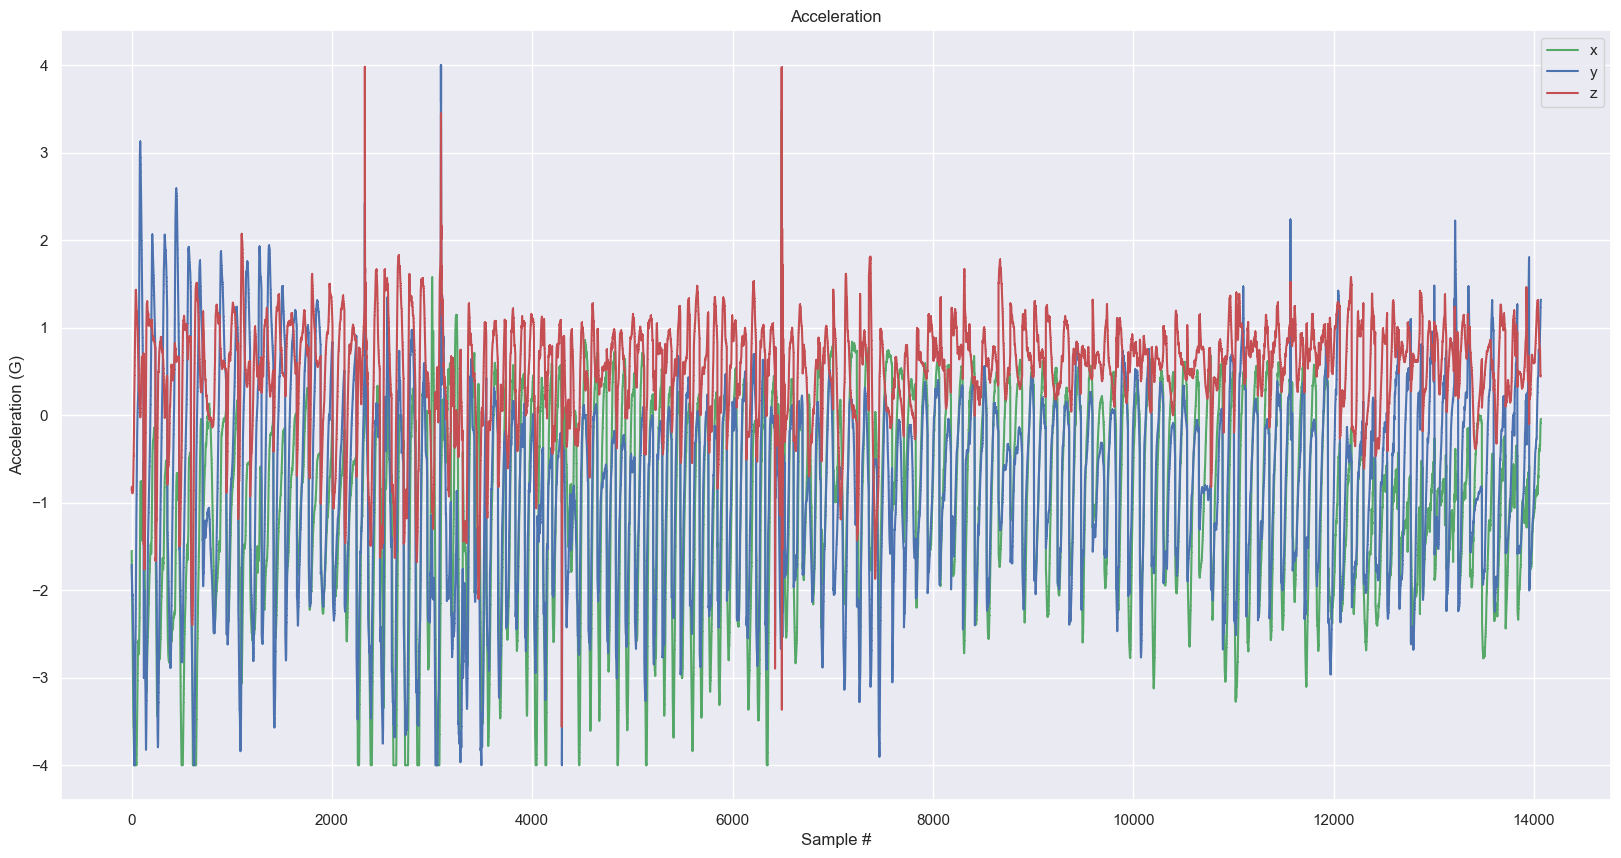

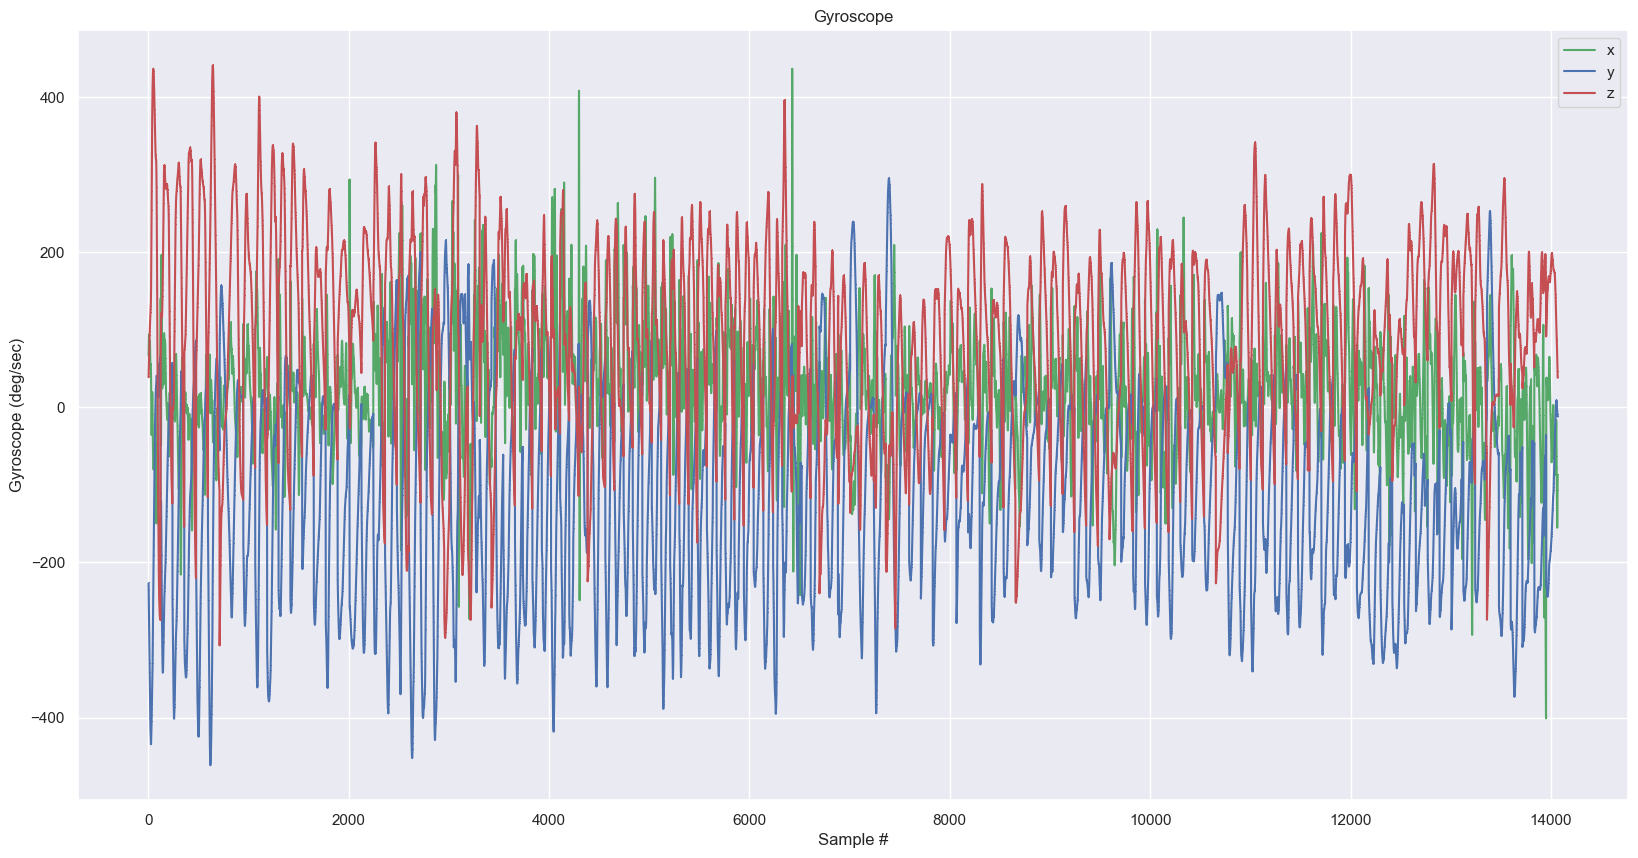

In [16]:
plot(df_forehand_low, ['aX', 'aY', 'aZ'], "Acceleration", "Acceleration (G)")
plot(df_forehand_low, ['gX', 'gY', 'gZ'], "Gyroscope", "Gyroscope (deg/sec)")

In [ ]:
plot(df_forehand_high, ['aX', 'aY', 'aZ'], "Acceleration", "Acceleration (G)")
plot(df_forehand_high, ['gX', 'gY', 'gZ'], "Gyroscope", "Gyroscope (deg/sec)")

In [ ]:
plot(df_backhand_low, ['aX', 'aY', 'aZ'], "Acceleration", "Acceleration (G)")
plot(df_backhand_low, ['gX', 'gY', 'gZ'], "Gyroscope", "Gyroscope (deg/sec)")

In [ ]:
plot(df_backhand_high, ['aX', 'aY', 'aZ'], "Acceleration", "Acceleration (G)")
plot(df_backhand_high, ['gX', 'gY', 'gZ'], "Gyroscope", "Gyroscope (deg/sec)")

# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [17]:
SEED = 1337 #set a fixed random seed value, for reproducibility, this will allow us to get same random numbers each time the notebook is run
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = ["forehand_low", "forehand_high", "backhand_low", "backhand_high"]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv('../data/'+ gesture + ".csv")

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  if num_recordings>120: num_recordings=120
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

Processing index 0 for gesture 'forehand_low'.
	There are 118 recordings of the forehand_low gesture.
Processing index 1 for gesture 'forehand_high'.
	There are 156 recordings of the forehand_high gesture.
Processing index 2 for gesture 'backhand_low'.
	There are 122 recordings of the backhand_low gesture.
Processing index 3 for gesture 'backhand_high'.
	There are 154 recordings of the backhand_high gesture.
Data set parsing and preparation complete.


## Train/Val/Test Split

#### Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [18]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs) #[0,]
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


#### Add stratified split to keep number of classes balanced

In [19]:
# Perform train-validation-test split
inputs_train_val, inputs_test, outputs_train_val, outputs_test = train_test_split(inputs, outputs,
                                                            stratify=outputs,
                                                            test_size=0.2)  # 20% of original data for testing

# Further split the combined training-validation set into train and validation sets
inputs_train, inputs_validate, outputs_train, outputs_validate = train_test_split(inputs_train_val, outputs_train_val,
                                                  stratify=outputs_train_val,
                                                  test_size=0.25)  # 20% of original 

## Model Training

#### Baseline Model

In [10]:
model_baseline = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(NUM_GESTURES, activation='softmax') 
])

model_baseline.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'accuracy'])

history_baseline = model_baseline.fit(inputs_train, outputs_train, epochs=100, batch_size=4, validation_data=(inputs_validate, outputs_validate))
model_baseline.summary()

Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.1882 - mae: 0.3744 - accuracy: 0.2455 - val_loss: 0.1852 - val_mae: 0.3725 - val_accuracy: 0.4000
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1845 - mae: 0.3703 - accuracy: 0.2970 - val_loss: 0.1897 - val_mae: 0.3699 - val_accuracy: 0.3636
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1816 - mae: 0.3651 - accuracy: 0.3091 - val_loss: 0.1798 - val_mae: 0.3643 - val_accuracy: 0.4182
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1779 - mae: 0.3609 - accuracy: 0.3364 - val_loss: 0.1758 - val_mae: 0.3602 - val_accuracy: 0.4545
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1752 - mae: 0.3570 - accuracy: 0.3576 - val_loss: 0.1754 - val_mae: 0.3565 - val_accuracy: 0.3636
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1726 - mae: 0.3523 - accuracy: 0.4152 - val_loss: 0.1716 - v

#### Model 1
- Increase #Hidden Layers & #Neurons

In [11]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')  # softmax for multiclass
])

model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'accuracy'])

history_1= model_1.fit(inputs_train, outputs_train, epochs=100, batch_size=4, validation_data=(inputs_validate, outputs_validate))
model_1.summary()

Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.1900 - mae: 0.3733 - accuracy: 0.2333 - val_loss: 0.1857 - val_mae: 0.3712 - val_accuracy: 0.2909
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1845 - mae: 0.3689 - accuracy: 0.2970 - val_loss: 0.1837 - val_mae: 0.3666 - val_accuracy: 0.3818
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1773 - mae: 0.3596 - accuracy: 0.3667 - val_loss: 0.1731 - val_mae: 0.3562 - val_accuracy: 0.4273
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1683 - mae: 0.3463 - accuracy: 0.4394 - val_loss: 0.1849 - val_mae: 0.3568 - val_accuracy: 0.3091
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1618 - mae: 0.3354 - accuracy: 0.4758 - val_loss: 0.1647 - val_mae: 0.3342 - val_accuracy: 0.4182
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1527 - mae: 0.3198 - accuracy: 0.5273 - val_loss: 0.1528 - v

#### Model 2
- Add dropout & L2 regularization

In [31]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')  
])

model_2.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'accuracy'])

history_2= model_2.fit(inputs_train, outputs_train, epochs=100, batch_size=4, validation_data=(inputs_validate, outputs_validate))
model_2.summary()

Epoch 1/100
83/83 [==============================] - 1s 4ms/step - loss: 0.4626 - mae: 0.3764 - accuracy: 0.2424 - val_loss: 0.3353 - val_mae: 0.3709 - val_accuracy: 0.3545
Epoch 2/100
83/83 [==============================] - 0s 2ms/step - loss: 0.2745 - mae: 0.3719 - accuracy: 0.3273 - val_loss: 0.2235 - val_mae: 0.3697 - val_accuracy: 0.2818
Epoch 3/100
83/83 [==============================] - 0s 2ms/step - loss: 0.2061 - mae: 0.3706 - accuracy: 0.3000 - val_loss: 0.1889 - val_mae: 0.3630 - val_accuracy: 0.3091
Epoch 4/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1886 - mae: 0.3652 - accuracy: 0.3455 - val_loss: 0.1846 - val_mae: 0.3627 - val_accuracy: 0.3909
Epoch 5/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1760 - mae: 0.3505 - accuracy: 0.4242 - val_loss: 0.1728 - val_mae: 0.3422 - val_accuracy: 0.4091
Epoch 6/100
83/83 [==============================] - 0s 2ms/step - loss: 0.1719 - mae: 0.3413 - accuracy: 0.4273 - val_loss: 0.1609 - v

#### Model 3 (Final  Model)
- Weight initialization
- Add early stopping & restore best model
- Experiment with diff activation fns/optimizers/batch sizes/learning rates

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')  # softmax for multiclass
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'accuracy'])

#callbacks
checkpoint=tf.keras.callbacks.ModelCheckpoint('model_best.keras')
early_stopping=tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(inputs_train, outputs_train, epochs=200, batch_size=4, validation_data=(inputs_validate, outputs_validate), callbacks=[checkpoint, early_stopping])


Epoch 1/200


83/83 [==============================] - 2s 5ms/step - loss: 0.6490 - mae: 0.3755 - accuracy: 0.2515 - val_loss: 0.4935 - val_mae: 0.3721 - val_accuracy: 0.3273
Epoch 2/200
83/83 [==============================] - 0s 2ms/step - loss: 0.4053 - mae: 0.3696 - accuracy: 0.3303 - val_loss: 0.3364 - val_mae: 0.3705 - val_accuracy: 0.2818
Epoch 3/200
83/83 [==============================] - 0s 3ms/step - loss: 0.2943 - mae: 0.3726 - accuracy: 0.3182 - val_loss: 0.2580 - val_mae: 0.3708 - val_accuracy: 0.2909
Epoch 4/200
83/83 [==============================] - 0s 2ms/step - loss: 0.2386 - mae: 0.3696 - accuracy: 0.3182 - val_loss: 0.2175 - val_mae: 0.3652 - val_accuracy: 0.3091
Epoch 5/200
83/83 [==============================] - 0s 2ms/step - loss: 0.2123 - mae: 0.3666 - accuracy: 0.3333 - val_loss: 0.1994 - val_mae: 0.3648 - val_accuracy: 0.3636
Epoch 6/200
83/83 [==============================] - 0s 2ms/step - loss: 0.1963 - mae: 0.3639 - accuracy: 0.3212 - val_loss: 0.1860 - val_mae: 0.35

In [37]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 64)                45760     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 32)                2080      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_52 (Dense)            (None, 16)                528       
                                                                 
 dense_53 (Dense)            (None, 4)                 68        
                                                                 
Total params: 48,436
Trainable params: 48,436
Non-tra

model=tf.keras.models.load_model('model_best.keras')

## Verify

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

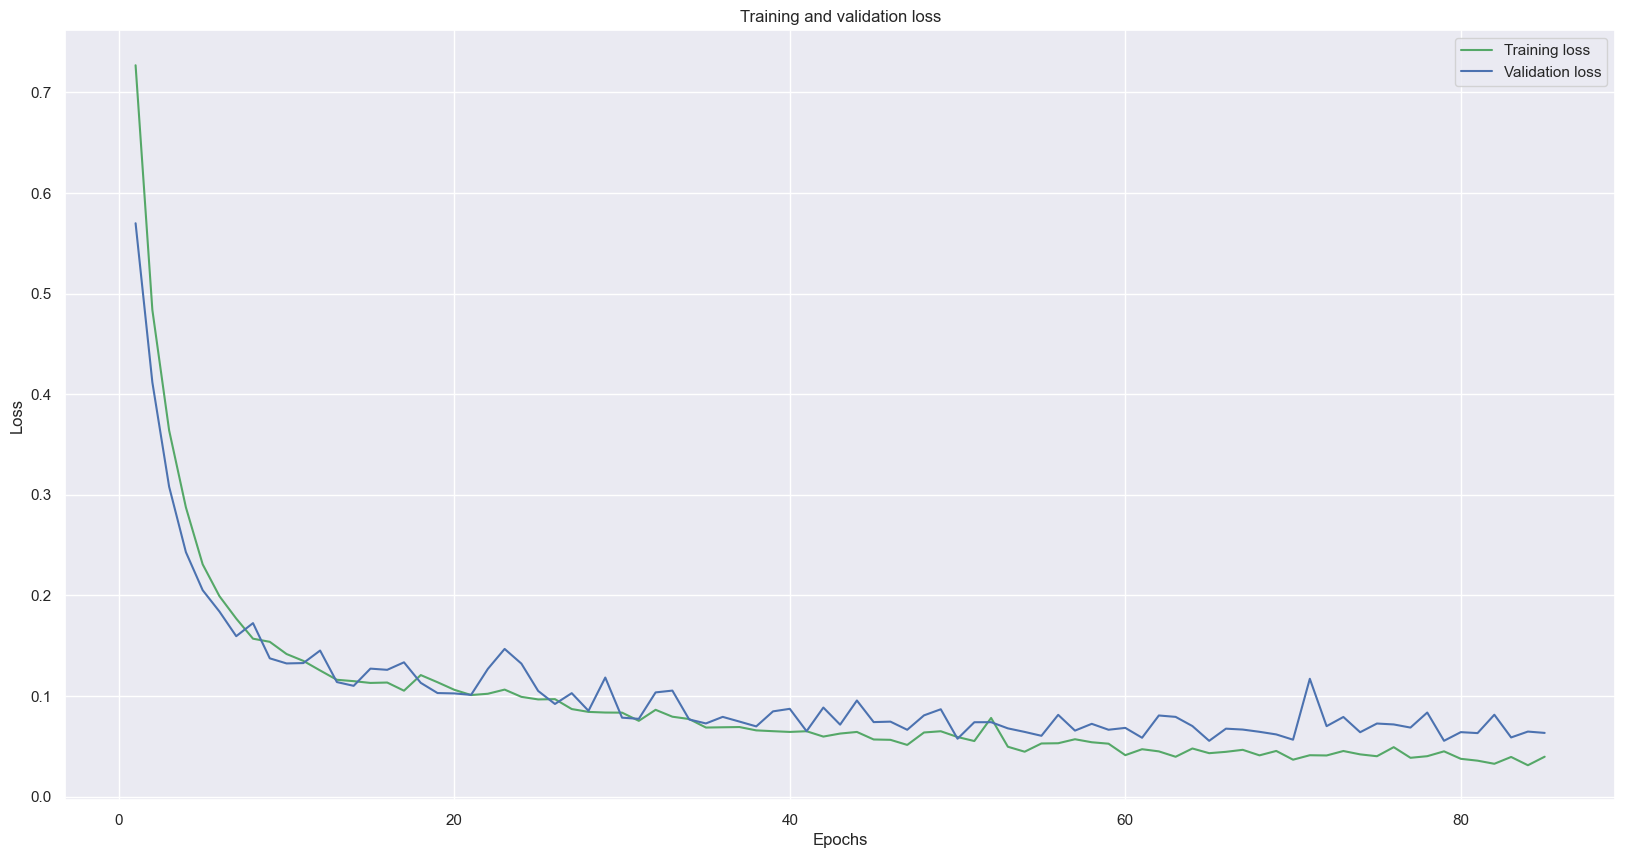

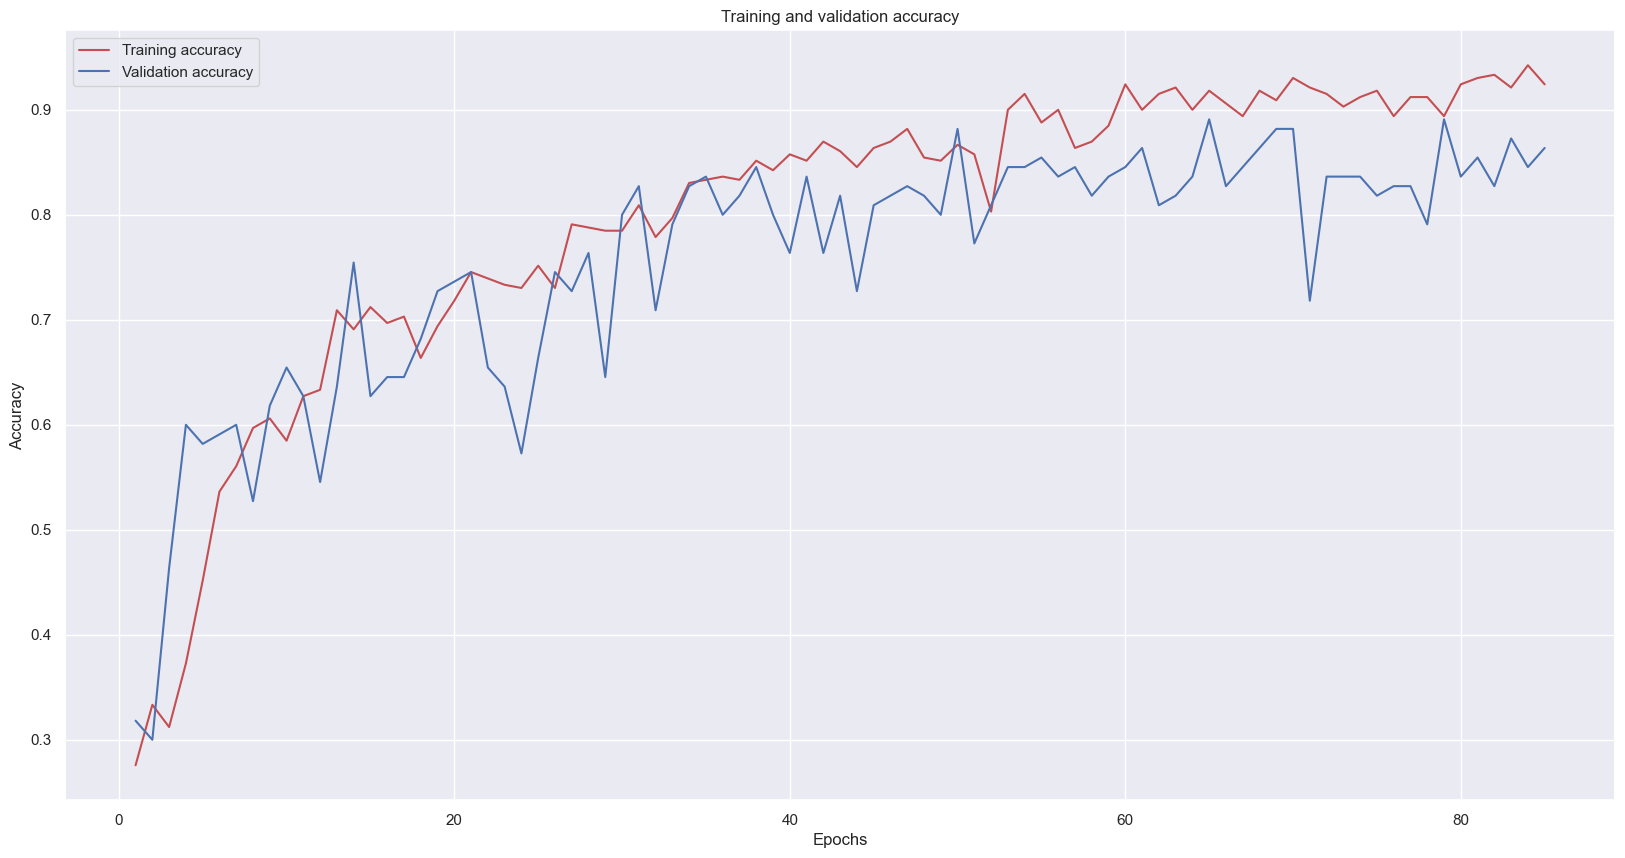

In [39]:
# Increase the size of the graphs
plt.rcParams["figure.figsize"] = (20, 10)

# Graph the loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid lines for better visualization
plt.show()

# Graph the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  # Add grid lines for better visualization
plt.show()

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

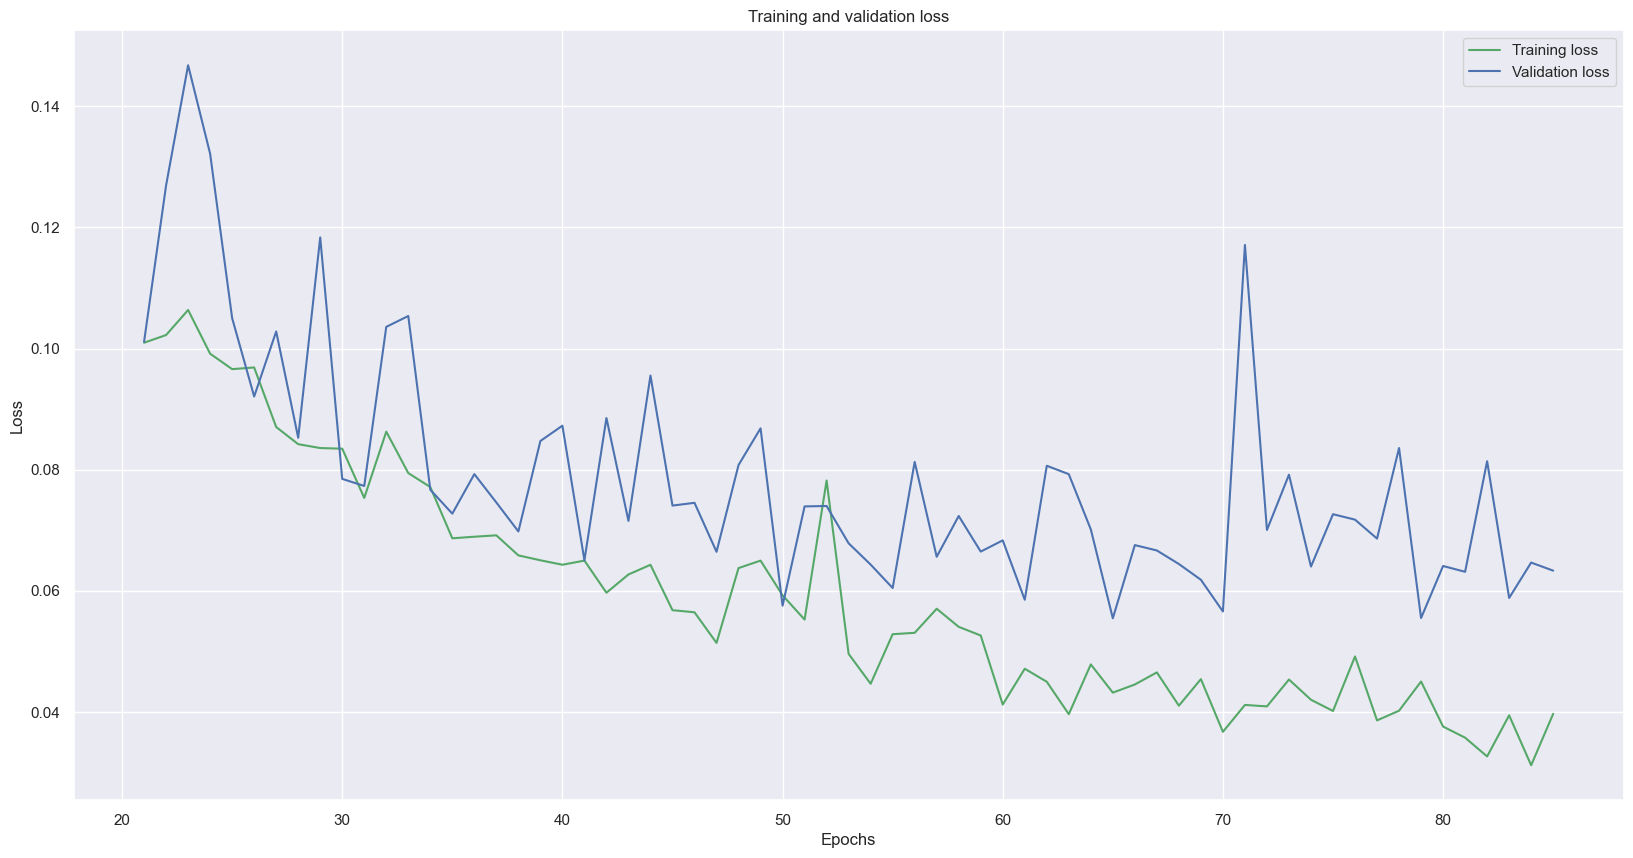

In [40]:
# graph the loss again skipping a bit of the start
SKIP = 20
plt.plot(epochs[SKIP:], loss[SKIP:], 'g', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



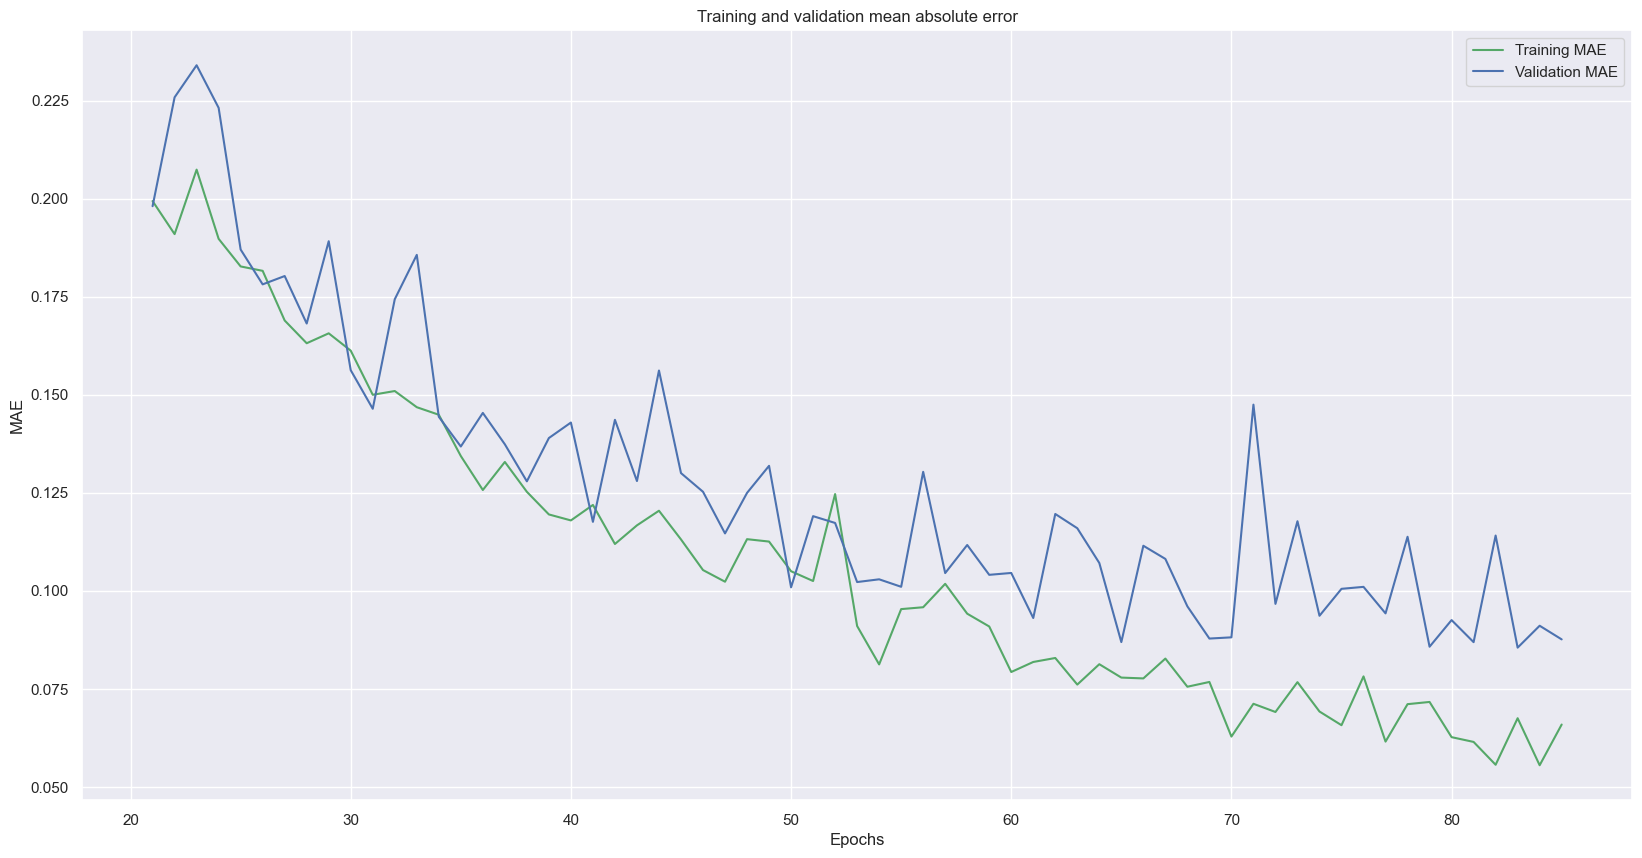

In [41]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


## Convert the Trained Model to TensorFlow Lite

In [20]:
model=tf.keras.models.load_model('model_final.keras')
model_size = os.path.getsize("model_best.keras")
model_size

623616

In [21]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("model.tflite")
print("Model is %d bytes" % basic_model_size)


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_generator():
  for value in inputs_test:
    # Each scalar value must be inside of a 2D array that is wrapped in a list
    yield [np.array(value, dtype=np.float32, ndmin=2)]
converter.representative_dataset = representative_dataset_generator
tflite_model = converter.convert()

open("model_quantized.tflite", "wb").write(tflite_model)

quantized_model_size = os.path.getsize("model_quantized.tflite")
print("Model is %d bytes" % quantized_model_size)

2024-04-19 19:41:46.367251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2024-04-19 19:41:46.383920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2024-04-19 19:41:46.587636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2024-04-19 19:41:46

INFO:tensorflow:Assets written to: /var/folders/ry/s39x6jls7kg80gzhq36cjjjw0000gn/T/tmp2759xmqn/assets


INFO:tensorflow:Assets written to: /var/folders/ry/s39x6jls7kg80gzhq36cjjjw0000gn/T/tmp2759xmqn/assets
2024-04-19 19:41:53.281952: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-04-19 19:41:53.281973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-04-19 19:41:53.282221: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/ry/s39x6jls7kg80gzhq36cjjjw0000gn/T/tmp2759xmqn
2024-04-19 19:41:53.284822: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-04-19 19:41:53.284838: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/ry/s39x6jls7kg80gzhq36cjjjw0000gn/T/tmp2759xmqn
2024-04-19 19:41:53.295170: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-04-19 19:41:53.377480: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

Model is 196668 bytes


2024-04-19 19:41:53.750092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2024-04-19 19:41:53.767068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2024-04-19 19:41:53.962468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2024-04-19 19:41:54

INFO:tensorflow:Assets written to: /var/folders/ry/s39x6jls7kg80gzhq36cjjjw0000gn/T/tmp66akxc85/assets


INFO:tensorflow:Assets written to: /var/folders/ry/s39x6jls7kg80gzhq36cjjjw0000gn/T/tmp66akxc85/assets


Model is 53384 bytes


/Users/remeliashirlley/anaconda3/envs/iot-tinyml/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2024-04-19 19:42:00.666482: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-04-19 19:42:00.666503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-04-19 19:42:00.666755: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/ry/s39x6jls7kg80gzhq36cjjjw0000gn/T/tmp66akxc85
2024-04-19 19:42:00.669650: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-04-19 19:42:00.669670: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/ry/s39x6jls7kg80gzhq36cjjjw0000gn/T/tmp66akxc85
2024-04

## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [22]:
!apt-get -qq install xxd #install xxd if it is not available
!xxd -i model_quantized.tflite > model.cc #save the file as a C src file
!cat model.cc #print src file

zsh:1: command not found: apt-get
unsigned char model_quantized_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x8c, 0x00, 0x00, 0x00, 0xe4, 0x00, 0x00, 0x00,
  0x10, 0xc1, 0x00, 0x00, 0x20, 0xc1, 0x00, 0x00, 0xd8, 0xcf, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x8a, 0x3c, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x3c, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,
  0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x90, 0xff, 0xff, 0xff,
  0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x64, 0x65, 0x6e, 0x73, 0x65, 0x5f, 0x35, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x0

In [23]:
# Function: Convert hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'

    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n'

        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [24]:
with open("model.h",'w') as file:
    file.write(hex_to_c_array(tflite_model,"model"))

In [25]:
# Instantiate an interpreter for each model
model = tf.lite.Interpreter('model.tflite')
model_quantized = tf.lite.Interpreter('model_quantized.tflite')

# Allocate memory for each model
model.allocate_tensors()
model_quantized.allocate_tensors()

# Get indexes of the input and output tensors
model_input_index = model.get_input_details()[0]["index"]
model_output_index = model.get_output_details()[0]["index"]
model_quantized_input_index = model_quantized.get_input_details()[0]["index"]
model_quantized_output_index = model_quantized.get_output_details()[0]["index"]

# Create arrays to store the results
model_predictions = []
model_quantized_predictions = []

# Run each model's interpreter for each value and store the results in arrays
for x_value in inputs_test:
  # Create a 2D tensor wrapping the current x value
  input_shape = model.get_input_details()[0]['shape']
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)
  x_value_tensor = np.reshape(x_value_tensor, input_shape)
  # Write the value to the input tensor
  model.set_tensor(model_input_index, x_value_tensor)
  # Run inference
  model.invoke()
  # Read the prediction from the output tensor
  model_predictions.append(
      model.get_tensor(model_output_index)[0])
  # Do the same for the quantized model
  model_quantized.set_tensor(model_quantized_input_index, x_value_tensor)
  model_quantized.invoke()
  model_quantized_predictions.append(
      model_quantized.get_tensor(model_quantized_output_index)[0])

In [26]:
pd.DataFrame(model_predictions)

,0,1,2,3
0,0.000152,0.999691,0.000001,0.000155
1,0.987204,0.011494,0.000069,0.001233
2,0.000076,0.999824,0.000018,0.000082
3,0.957280,0.037699,0.000599,0.004422
4,0.000135,0.001646,0.974250,0.023968
...,...,...,...,...
91,0.001272,0.009021,0.976246,0.013461
92,0.001143,0.005378,0.938400,0.055080
93,0.000588,0.010573,0.949928,0.038911
94,0.983853,0.013456,0.000145,0.002546


### Run with Test Data for quantized & unquantized models
Put our test data into the model and plot the predictions


In [27]:
def plot_confusion_matrix(predictions):
    ground_truth_labels = np.argmax(outputs_test, axis=1)
    predicted_labels = np.argmax(predictions, axis=1)

    conf_matrix=confusion_matrix(ground_truth_labels,predicted_labels)

    class_names = ['FL', 'FH', 'BL', 'BH']
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                horizontalalignment="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Display the plot
    plt.show()

Unquantized model

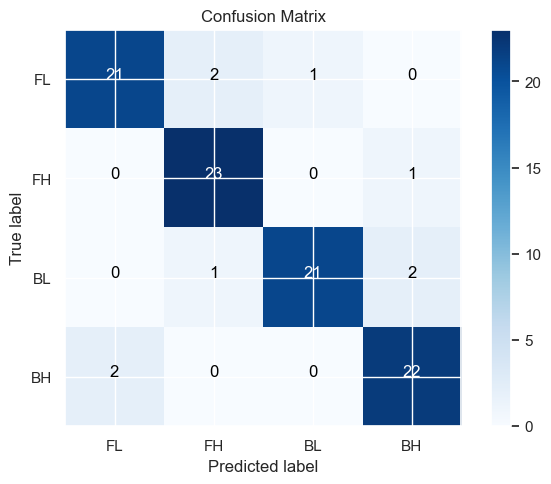

In [31]:
plot_confusion_matrix(model_predictions)

Quantized model

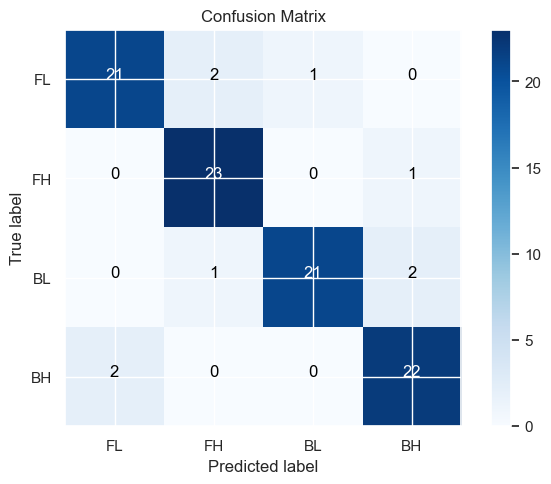

In [28]:
plot_confusion_matrix(model_quantized_predictions)